## Import Packages and Data

In [1]:
# AYU CODE
import pickle

from scipy import fft
from qtn.bimax import BiMax
from qtn.util import (boltzmann, emass, echarge, permittivity, cspeed, fperp, fp)
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from pyspedas import wind
from pytplot import tplot, get_data
import pandas as pd
import time
import netCDF4 as nc
from functions import Timer
%matplotlib inline

In [2]:
T = Timer.Timer()
T.start()

In [3]:
ant_len = 50      # m (monopole) 
ant_rad = 1.9e-4  # m
base_cap = 20e-12 # Farad
fbins = np.array([4000*1.0445**i for i in range(96)])

In [5]:
def find_closest_time(time, lst):
    """
    A function used to find the index of the closest time in a list 
    to the specific time held in the variable time
    """
    return min(range(len(lst)), key=lambda i: abs(time-lst[i]))

In [2]:
#data = wind.waves(trange=['1995-6-25', '1995-6-26'],get_support_data=True)
ds =  nc.Dataset("data/wi_wav_tnr_19950625.nc")
print(ds)
print(np.size(ds["tnr_ch1_time"][:]))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): n_times(19419), n_bins(96)
    variables(dimensions): float64 tnr_ch1_time(n_times), float64 tnr_ch1_freq(n_bins), float64 tnr_ch1_spec(n_bins, n_times)
    groups: 
19419


## Plot 1: June 25, 1995 06:33:06.432

### Theoretical

Need to import data for:
vsw: Solar Wind Speed - Solar Wind Experiment(SWE)
tc: core electron temperature
fpe: core electron plasma frequency - 
n: 

In [6]:
vsw=3.966e5
tc = 9.91 * echarge/boltzmann
t = 6.57
n = 0.026
tep = 9.91/9.62
fpe = 31.47e3

In [2]:
9.91 * echarge/boltzmann

115000.78664972584

In [7]:
ne = 12.28e6
nc = ne/(1+n)
ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2)
lrel = ant_len/ldc
print(lrel)

7.391617810601882


In [8]:
wrelplot = fbins/fpe

In [9]:
print(f"BiMax({ant_len}, {ant_rad}, {base_cap})")
print(f"p.gamma_shot({wrelplot[0]}, {lrel}, {n}, {t}, {tc})")

BiMax(50, 0.00019, 2e-11)
p.gamma_shot(0.1271051795360661, 7.391617810601882, 0.026, 6.57, 115000.78664972584)


In [10]:
p = BiMax(ant_len, ant_rad, base_cap,False)

In [11]:
T.lap("Gamma_shot")
g_s = np.array([p.gamma_shot(wrel, lrel, n, t, tc) for wrel in wrelplot])
print(g_s)

[[mpf('1.3211749400305373') mpf('2.4834249295966167e-15')]
 [mpf('1.3211288694057881') mpf('2.2757215078800376e-15')]
 [mpf('1.3211044156431742') mpf('2.0856526550310722e-15')]
 [mpf('1.3211447223342081') mpf('1.912180012377556e-15')]
 [mpf('1.3211092661633683') mpf('1.7523632216937433e-15')]
 [mpf('1.3210672357600313') mpf('1.6058427785347758e-15')]
 [mpf('1.3211129981611993') mpf('1.4723265816065555e-15')]
 [mpf('1.3210345323465886') mpf('1.3489358282601879e-15')]
 [mpf('1.3210572481875746') mpf('1.2366151998954693e-15')]
 [mpf('1.3211070655582489') mpf('1.1338266480006653e-15')]
 [mpf('1.3210040236491418') mpf('1.0386575568069031e-15')]
 [mpf('1.320996770678573') mpf('9.5200822015109545e-16')]
 [mpf('1.3210661413076821') mpf('8.7297773416223657e-16')]
 [mpf('1.3209441850763133') mpf('7.9961697514975126e-16')]
 [mpf('1.3209085978690873') mpf('7.327903011424727e-16')]
 [mpf('1.3209919962015952') mpf('6.7201491809132801e-16')]
 [mpf('1.3209006231946823') mpf('6.1565356584936881e-16')]


In [12]:
def helper(wrel):
    """
    add precision control to bimax function.
    
    """
    if wrel > 1 and wrel < 1.2:
        mp.mp.dps = 40
    else:
        mp.mp.dps = 20
    #mp.mp.dps = 3
    return p.bimax(wrel, lrel, n, t, tc)

In [13]:
T.lap("Enoise")
enoise = np.array([helper(wrel) for wrel in wrelplot])

In [14]:
#Modified by AYU 
# - Was running into an parameter error 
# - need to fix to match up with reference graph
#pnoise = np.array([p.proton(wrel*np.sqrt(1+n), ne, n, t, tep, tc, vsw) for wrel in wrelplot])
T.lap("Pnoise")
pnoise = np.array([p.proton2(wrel*np.sqrt(1+n), lrel, tep, tc, vsw) for wrel in wrelplot])

In [15]:
T.lap("Addition")
gamma = g_s[:, 0]
shot = g_s[:, 1]
vr2 = enoise + pnoise + shot

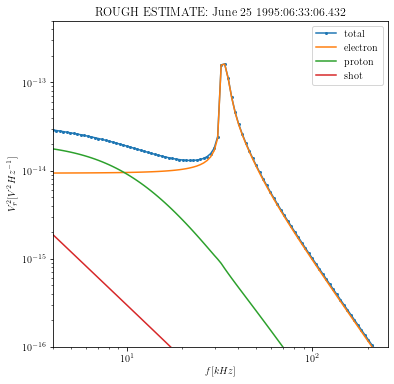

In [16]:
T.lap("Plot")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6], facecolor='w')
plt.plot(fbins/1000, vr2/gamma, 'o-', markersize=2, label='total')
plt.plot(fbins/1000, enoise/gamma, label='electron')
plt.plot(fbins/1000, pnoise/gamma, label='proton')
plt.plot(fbins/1000, shot/gamma, label='shot')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('ROUGH ESTIMATE: June 25 1995:06:33:06.432')
plt.legend(loc='best')
plt.show()

In [17]:
T.stop()
print(T.summary())

Total Time: 153.8494327068
Name: Elapsed Time
Gamma_shot: 108.5698974133
Enoise: 44.271876812
Pnoise: 0.6869516373
Addition: 0.009468317
Plot: 0.2720274925



In [22]:
mpf = mp.mpf
vr2_reduce = [mpf('3.81639e-14'),
mpf('3.76435e-14'),
mpf('3.71023e-14'),
mpf('3.65541e-14'),
mpf('3.5999e-14'),
mpf('3.54369e-14'),
mpf('3.48749e-14'),
mpf('3.42712e-14'),
mpf('3.36675e-14'),
mpf('3.305e-14'),
mpf('3.24255e-14'),
mpf('3.18079e-14'),
mpf('3.11903e-14'),
mpf('3.05381e-14'),
mpf('2.98719e-14'),
mpf('2.91989e-14'),
mpf('2.85189e-14'),
mpf('2.78388e-14'),
mpf('2.71519e-14'),
mpf('2.64441e-14'),
mpf('2.57572e-14'),
mpf('2.50945e-14'),
mpf('2.44492e-14'),
mpf('2.37935e-14'),
mpf('2.31551e-14'),
mpf('2.25549e-14'),
mpf('2.19477e-14'),
mpf('2.13544e-14'),
mpf('2.07855e-14'),
mpf('2.02477e-14'),
mpf('1.97516e-14'),
mpf('1.93144e-14'),
mpf('1.88877e-14'),
mpf('1.84991e-14'),
mpf('1.81521e-14'),
mpf('1.78503e-14'),
mpf('1.76144e-14'),
mpf('1.73958e-14'),
mpf('1.72466e-14'),
mpf('1.71703e-14'),
mpf('1.71876e-14'),
mpf('1.73229e-14'),
mpf('1.76109e-14'),
mpf('1.80932e-14'),
mpf('1.89293e-14'),
mpf('2.04038e-14'),
mpf('2.33702e-14'),
mpf('3.14471e-14'),
mpf('2.04115e-13'),
mpf('2.13801e-13'),
mpf('1.4902e-13'),
mpf('9.17599e-14'),
mpf('6.22141e-14'),
mpf('4.59979e-14'),
mpf('3.57006e-14'),
mpf('2.84911e-14'),
mpf('2.31135e-14'),
mpf('1.89432e-14'),
mpf('1.57027e-14'),
mpf('1.28855e-14'),
mpf('1.10103e-14'),
mpf('9.29985e-15'),
mpf('7.8982e-15'),
mpf('6.73506e-15'),
mpf('5.76535e-15'),
mpf('4.95264e-15'),
mpf('4.26482e-15'),
mpf('3.68282e-15'),
mpf('3.18712e-15'),
mpf('2.76515e-15'),
mpf('2.39999e-15'),
mpf('2.08644e-15'),
mpf('1.81669e-15'),
mpf('1.5825e-15'),
mpf('1.37932e-15'),
mpf('1.20303e-15'),
mpf('1.05038e-15'),
mpf('9.18102e-16'),
mpf('8.0231e-16'),
mpf('7.0072e-16'),
mpf('6.12683e-16'),
mpf('5.36463e-16'),
mpf('4.69893e-16'),
mpf('4.11997e-16'),
mpf('3.60497e-16'),
mpf('3.15449e-16'),
mpf('2.76472e-16'),
mpf('2.42265e-16'),
mpf('2.12341e-16'),
mpf('1.86293e-16'),
mpf('1.63687e-16'),
mpf('1.43684e-16'),
mpf('1.26093e-16'),
mpf('1.10534e-16'),
mpf('9.69141e-17'),
mpf('8.51505e-17')]

In [28]:
np.mean(np.divide(np.subtract(vr2,vr2_reduce), vr2))

mpf('0.00039537963642061569892046')

In [19]:
#fig.savefig('plots/wind19950625_theoretical_rough.png', dpi=300)

In [20]:
raise error
fig.savefig('plots/wind19950625_theoretical.png', dpi=300)

NameError: name 'error' is not defined

### Experimental

#m_dat=readsav('/Users/Tong/Google Drive/research/data/meudon_tnr/TNR_XY_ACE_19950625.sav')
#data = wind.waves(trange=['1995-6-25', '1995-6-26'],get_support_data=True)


#tplot(['E_VOLTAGE_TNR'])

# Here I imported the Voltage TNR data and tried to find the epoch time
# Converting 
export_data = get_data('E_VOLTAGE_TNR')
min_data = get_data('Minimum_voltage_TNR')
df = pd.DataFrame(export_data.y)
#df.describe()
loc = min(range(len(export_data.times)), key=lambda i: abs(804061986.432-export_data.times[i]))
#print(np.shape(export_data.y))
#print(export_data.times[loc], loc)
#print("TARGET TIME: "+str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(804061986))))

#print("Closest times to Target Time")
#print(str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(export_data.times[loc-1]))))
print(str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(export_data.times[loc]))))
#print(str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(export_data.times[loc+1]))))

oldTime = export_data.times[0]-60
for time in export_data.times:
    if oldTime + 60 != time:
        print(time)
    oldTime = time

data = wind.waves(trange=['1995-6-25', '1995-6-26'],get_support_data=True)

In [3]:
string = """-130.124 -131.359 -132.755 -134.210 -135.386 -136.499 -137.461 -138.111
 -138.560 -138.697 -139.057 -139.141 -139.279 -139.415 -139.462 -139.769
 -139.686 -139.964 -140.331 -140.741 -140.971 -141.090 -141.485 -141.904
 -142.199 -142.432 -142.835 -143.315 -143.951 -144.490 -145.242 -146.096
 -148.075 -148.554 -149.031 -149.393 -149.864 -150.162 -150.550 -150.919
 -151.406 -151.835 -152.209 -152.690 -153.167 -153.531 -152.790 -152.539
 -153.934 -154.355 -154.585 -154.704 -154.938 -155.145 -155.330 -155.495
 -155.808 -156.006 -156.193 -156.279 -156.423 -156.356 -156.243 -156.101
 -156.739 -156.883 -157.240 -157.343 -157.367 -157.680 -157.756 -157.461
 -157.421 -158.109 -153.938 -155.412 -157.632 -158.470 -157.843 -157.209
 -158.312 -158.744 -159.215 -158.993 -158.936 -159.120 -159.320 -159.747
 -159.752 -159.640 -156.215 -156.530 -157.592 -159.019 -157.112 -156.001"""
lst = string.split(" ")
lst = [float(num) for num in lst]
print([10**(num/10) for num in lst])

[9.7185170294017e-14, 7.313074538624811e-14, 5.302735926292154e-14, 3.793149849736809e-14, 2.89334352339151e-14, 2.2392366825123616e-14, 1.794320421716837e-14, 1.5448986725154426e-14, 1.3931568029453036e-14, 1.3498950350559801e-14, 1.2425103069290103e-14, 1.2187089485092812e-14, 1.1805924458138925e-14, 1.1441948798169872e-14, 1.131878993655418e-14, 1.0546297058996503e-14, 1.0749790488200815e-14, 1.0083237577615525e-14, 9.26616437493746e-15, 8.431405951147685e-15, 7.996501075653532e-15, 7.78036551039804e-15, 7.1039517000295234e-15, 6.450598332848311e-15, 6.0269834652118385e-15, 5.712155216230454e-15, 5.205950088015483e-15, 4.66122428001887e-15, 4.026243159764705e-15, 3.55631318568984e-15, 2.9908869650638324e-15, 2.4569708276368362e-15, 1.557758034831605e-15, 1.3950828503573704e-15, 1.2499711805783696e-15, 1.1500057186992375e-15, 1.0318106352675928e-15, 9.63385266142348e-16, 8.81048873008011e-16, 8.092822218443724e-16, 7.234358058506338e-16, 6.553902858334767e-16, 6.013121787899332e-16, 

Target Time: 25 Jun 1995 06:33:06
Time Found: 25 Jun 1995 06:33:08.6399999856948853
(96,)


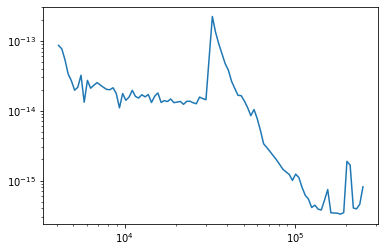

In [6]:
#export_data = get_data('E_VOLTAGE_TNR')
#min_data = get_data('Minimum_voltage_TNR')

#loc = min(range(len(export_data.times)), key=lambda i: abs(804061986.432-export_data.times[i]))
#spec = export_data.y[loc][:]
#min_spec = min_data.y[0][:]
#freq = export_data.v

loc = find_closest_time(804061986.432, ds["tnr_ch1_time"])
print(f"Target Time: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(804061986.432))}")
print(f"Time Found: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(int(ds['tnr_ch1_time'][loc])))}{str(ds['tnr_ch1_time'][loc]%1)[1:]}")
spec = ds["tnr_ch1_spec"][:, loc][:]
freq = ds["tnr_ch1_freq"][:]
#print(spec)

spec /= 1e6

#spec = np.multiply(spec,min_spec)

spec = spec**2
spec -= [10**(num/10) for num in lst]

print(np.shape(spec))

plt.plot(freq, spec)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [7]:
spec

masked_array(data=[8.59425599e-14, 7.66795662e-14, 5.35075073e-14,
                   3.33683183e-14, 2.67760351e-14, 1.96137318e-14,
                   2.16234888e-14, 3.21054604e-14, 1.32089552e-14,
                   2.71362081e-14, 2.09506781e-14, 2.30677169e-14,
                   2.51935956e-14, 2.33222000e-14, 2.15802293e-14,
                   2.01628737e-14, 1.99320880e-14, 2.12632150e-14,
                   1.76198087e-14, 1.09706565e-14, 1.75899955e-14,
                   1.40808541e-14, 1.56462588e-14, 1.95157205e-14,
                   1.60068849e-14, 1.51555570e-14, 1.69102911e-14,
                   1.57576200e-14, 1.70404426e-14, 1.30785421e-14,
                   1.61033409e-14, 1.79135755e-14, 1.31238636e-14,
                   1.39080174e-14, 1.35090727e-14, 1.46845656e-14,
                   1.30160573e-14, 1.32561003e-14, 1.35539835e-14,
                   1.23245478e-14, 1.36053284e-14, 1.36581308e-14,
                   1.29588454e-14, 1.25662432e-14, 1.56516712e

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6], facecolor="white")
plt.plot(fbins/1000, vr2/gamma, label='theory')
#plt.plot(fbins/1000, enoise/gamma, label='electron')
#plt.plot(fbins/1000, pnoise/gamma, label='proton')
#plt.plot(fbins/1000, shot/gamma, label='shot')
plt.plot(fbins/1000, spec, 'o', markersize=3, label='WIND data')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 25 1995:06:33:08.639')
#plt.title('June 25 1995:06:33:06.432')
plt.legend(loc='best')
#plt.axvline(x=31.924165899128376)
plt.show()
fig.savefig('plots/wind19950625.png', dpi=500)

## Plot 2: June 25, 1995 18:52:34.344 GMT

In [ ]:
assert False

### Theoretical

In [ ]:
vsw=7.61e5
tc = 11.53 * echarge/boltzmann
t = 5.57
n = 0.059
tep = 11.53/47.49
fpe = 22.24e3
te = tc * (1 + n)/(1 + n/t)
print(te)
te = te

In [ ]:
ne = 6.13e6
nc = ne/(1+n)
ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2)
lc = ant_len/ldc
print(lc)
lde = np.sqrt(permittivity * boltzmann * te/ ne / echarge**2)
le = ant_len/lde
print(le)

In [ ]:
p = BiMax(ant_len, ant_rad, base_cap)

In [ ]:
wrelplot = fbins/fpe

In [ ]:
#wrelplot = wrelplot[0:2]

In [ ]:
g_s = np.array([p.gamma_shot(wrel, lrel, n, t, tc) for wrel in wrelplot])

In [ ]:
wrelplot[0]

In [ ]:
wrel = wrelplot[0]
print(p.gamma_shot(wrel, lrel, n, t, tc))
print(p.proton2(wrel, lc, tep, tc, vsw))
print(p.proton2(wrel, le, tep, te, vsw))

In [ ]:
p.proton2(0.1, le, tep, te, vsw)

In [ ]:
def helper(wrel):
    """
    add precision control to bimax function.
    
    """
    if wrel > 1 and wrel < 1.2:
        mp.mp.dps = 40
    else:
        mp.mp.dps = 20
    return p.bimax(wrel, lrel, n, t, tc)

In [ ]:
enoise = np.array([helper(wrel) for wrel in wrelplot])

In [ ]:
pnoise = np.array([p.proton2(wrel*np.sqrt(1+n), lrel, tep, tc, vsw) for wrel in wrelplot])

In [ ]:
fig = plt.figure(figsize=[6, 6])
plt.plot(fbins/1000, pnoise, label='proton')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 19 1995:18:52:35.344')
plt.legend(loc='best')
plt.show()

In [ ]:
gamma = g_s[:, 0]
shot = g_s[:, 1]
vr2 = enoise + pnoise + shot

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6])
plt.plot(fbins/1000, vr2/gamma, 'o-', markersize=2, label='total')
plt.plot(fbins/1000, enoise/gamma, label='electron')
plt.plot(fbins/1000, pnoise/gamma, label='proton')
plt.plot(fbins/1000, shot/gamma, label='shot')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 19 1995:18:52:35.344')
plt.legend(loc='best')
plt.show()

In [ ]:
fig.savefig('plots/wind19950619_theoretical.png', dpi=300)

### Experimental

In [ ]:
#m_dat=readsav('/Users/Tong/Google Drive/research/data/meudon_tnr/TNR_XY_ACE_19950619.sav')
#export_data = get_data('E_VOLTAGE_TNR')
#min_data = get_data('Minimum_voltage_TNR')

#loc = min(range(len(export_data.times)), key=lambda i: abs(804106352.344-export_data.times[i]))

#spec = export_data.y[loc][:]
#min_spec = min_data.y[0][:]
#freq = export_data.v

loc = find_closest_time(804106352.344, ds["tnr_ch1_time"][:])-1
print(f"Target Time: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(804061986.432))}")
print(f"Time Found: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(int(ds['tnr_ch1_time'][loc])))}{str(ds['tnr_ch1_time'][loc]%1)[1:]}")
spec = ds["tnr_ch1_spec"][:, loc][:]
freq = ds["tnr_ch1_freq"][:]
#spec = 10. ** (spec/10.)
spec /= 1e6

#spec = np.multiply(spec,min_spec)

spec = spec**2

plt.plot(freq, spec)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6], facecolor="white")
plt.plot(fbins/1000, vr2/gamma, label='theory')
#plt.plot(fbins/1000, enoise/gamma, label='electron')
#plt.plot(fbins/1000, pnoise/gamma, label='proton')
#plt.plot(fbins/1000, shot/gamma, label='shot')
plt.plot(fbins/1000 * 1.02, spec, 'o', markersize=2, label='WIND data')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-18, 1e-10])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('19-JUN-1995, 18:52:32.400')
plt.legend(loc='best')
plt.show()

In [ ]:
fig.savefig('plots/wind19950619.png', dpi=300)